In [ ]:
import math
from collections import defaultdict
from itertools import chain
from torch.optim import Optimizer
import torch
import warnings

class Lookahead(Optimizer):
    def __init__(self, optimizer, k=5, alpha=0.5):
        self.optimizer = optimizer
        self.k = k
        self.alpha = alpha
        self.param_groups = self.optimizer.param_groups
        self.state = defaultdict(dict)
        self.fast_state = self.optimizer.state
        for group in self.param_groups:
            group["counter"] = 0
    
    def update(self, group):
        for fast in group["params"]:
            param_state = self.state[fast]
            if "slow_param" not in param_state:
                param_state["slow_param"] = torch.zeros_like(fast.data)
                param_state["slow_param"].copy_(fast.data)
            slow = param_state["slow_param"]
            slow += (fast.data - slow) * self.alpha
            fast.data.copy_(slow)
    
    def update_lookahead(self):
        for group in self.param_groups:
            self.update(group)

    def step(self, closure=None):
        loss = self.optimizer.step(closure)
        for group in self.param_groups:
            if group["counter"] == 0:
                self.update(group)
            group["counter"] += 1
            if group["counter"] >= self.k:
                group["counter"] = 0
        return loss

    def state_dict(self):
        fast_state_dict = self.optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict["state"]
        param_groups = fast_state_dict["param_groups"]
        return {
            "fast_state": fast_state,
            "slow_state": slow_state,
            "param_groups": param_groups,
        }

    def load_state_dict(self, state_dict):
        slow_state_dict = {
            "state": state_dict["slow_state"],
            "param_groups": state_dict["param_groups"],
        }
        fast_state_dict = {
            "state": state_dict["fast_state"],
            "param_groups": state_dict["param_groups"],
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.optimizer.load_state_dict(fast_state_dict)
        self.fast_state = self.optimizer.state

    def add_param_group(self, param_group):
        param_group["counter"] = 0
        self.optimizer.add_param_group(param_group)

def centralized_gradient(x,use_gc=True,gc_conv_only=False):
    if use_gc:
      if gc_conv_only:
        if len(list(x.size()))>3:
            x.add_(-x.mean(dim = tuple(range(1,len(list(x.size())))), keepdim = True))
      else:
        if len(list(x.size()))>1:
            x.add_(-x.mean(dim = tuple(range(1,len(list(x.size())))), keepdim = True))
    return x

class AdamGC(Optimizer):
    r"""Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False,use_gc=False, gc_conv_only=False,gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(AdamGC, self).__init__(params, defaults)
        self.gc_loc=gc_loc
        self.use_gc=use_gc
        self.gc_conv_only=gc_conv_only

    def __setstate__(self, state):
        super(AdamGC, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])
                if self.gc_loc:
                   grad=centralized_gradient(grad,use_gc=self.use_gc,gc_conv_only=self.gc_conv_only)
                    
                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1
                #GC operation 
                G_grad=exp_avg/denom 
                if self.gc_loc==False:       
                    G_grad=centralized_gradient(G_grad,use_gc=self.use_gc,gc_conv_only=self.gc_conv_only)
                
                p.add_( G_grad, alpha=-step_size)

        return loss

In [ ]:
# !pip3 install torch-lr-finder
# !pip3 install pyDOE
# !pip3 install torchmeta
# !pip3 install learn2learn
# !pip3 install git+https://github.com/numenta/nupic.torch.git
# print('Done!!! installing packages')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Colab Notebooks/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# importing libs
import time
import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch_lr_finder import LRFinder

from nupic.torch.modules import (KWinners, SparseWeights, Flatten, rezero_weights, update_boost_strength)

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pyDOE import lhs
import learn2learn as l2l
from learn2learn.optim.transforms import MetaCurvatureTransform

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class CrossStich(nn.Module):
    def __init__(self,):
        super(CrossStich, self).__init__()
        self.transform = nn.Parameter(data=torch.eye(2), requires_grad=True)
    def forward(self, input_1, input_2):
        return self.transform[0][0]*input_1 + self.transform[0][1]*input_2, self.transform[1][0]*input_1 + self.transform[1][1]*input_2

# MLP configuration
INPUT_SIZE = 2  
SPARSE_HIDDEN_SIZE = 2048
HIDDEN_SIZE = 50
OUTPUT_SIZE = 1

# Sparsity parameters
SPARSITY = 0.2

class MLTSparseModel(nn.Module):
    def __init__(self, INPUT_SIZE, SPARSE_HIDDEN_SIZE, HIDDEN_SIZE, OUTPUT_SIZE):
        super().__init__()
        self.sparse1 = SparseWeights(nn.Linear(INPUT_SIZE, SPARSE_HIDDEN_SIZE), sparsity=SPARSITY)
        self.sparse2 = SparseWeights(nn.Linear(SPARSE_HIDDEN_SIZE, SPARSE_HIDDEN_SIZE), sparsity=SPARSITY)

        # Task1
        self.hidden1_t1 = nn.Linear(SPARSE_HIDDEN_SIZE, HIDDEN_SIZE)
        self.hidden2_t1 = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)

        # Task2
        self.hidden1_t2 = nn.Linear(SPARSE_HIDDEN_SIZE, HIDDEN_SIZE)
        self.hidden2_t2 = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)

        self.cross_stitch = CrossStich()

    def forward(self, x):
        x = self.swish(self.sparse1(x))
        x = self.swish(self.sparse2(x))
        
        x_t1 = self.swish(self.hidden1_t1(x))
        x_t2 = self.swish(self.hidden1_t2(x))

        x_t1, x_t2 = self.cross_stitch(x_t1, x_t2)

        x_t1 = self.swish(self.hidden2_t1(x_t1))
        x_t2 = self.swish(self.hidden2_t2(x_t2))
        
        return x_t1, x_t2

    def swish(self, x):
        return x*torch.sigmoid(x)

In [ ]:
torch.cuda.empty_cache()
sparse_solver = MLTSparseModel(INPUT_SIZE, SPARSE_HIDDEN_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).cuda()

In [ ]:
def get_fxy(X_f, constant):
    return -constant*(np.sin(np.pi*X_f[:, 0:1])*np.sin(np.pi*X_f[:, 1:2]))

lb = 0
ub = 1
N_f = 200 # for toy experiment (should be like 1000?)
n_tasks = 12000
n_b_conditions = 4
N_b = 64 # for toy experiment (should be like 200?)

def get_interior_data(X_f, constant):
    X_f = np.hstack((X_f, get_fxy(X_f, constant), get_fxy(X_f, constant-1+2*np.random.rand())))
    return X_f

def get_boundary_data(constant, N_b, n_b_conditions):
    X_b1 = np.zeros((N_b//n_b_conditions, 4))
    X_b1[:, 0:1] = lb + (ub-lb)*lhs(1, N_b//n_b_conditions)
    X_b1[:, 1:2] = 0
    X_b1[:, 2:3] = 0
    X_b1[:, 3:4] = 0

    X_b2 = np.zeros((N_b//n_b_conditions, 4))
    X_b2[:, 0:1] = lb + (ub-lb)*lhs(1, N_b//n_b_conditions)
    X_b2[:, 1:2] = 1
    X_b2[:, 2:3] = get_fxy(X_b2, constant)
    X_b2[:, 3:4] = get_fxy(X_b2, constant-1+2*np.random.rand())

    X_b3 = np.zeros((N_b//n_b_conditions, 4))
    X_b3[:, 0:1] = 0
    X_b3[:, 1:2] = lb + (ub-lb)*lhs(1, N_b//n_b_conditions)
    X_b3[:, 2:3] = 0
    X_b3[:, 3:4] = 0

    X_b4 = np.zeros((N_b//n_b_conditions, 4))
    X_b4[:, 0:1] = 1
    X_b4[:, 1:2] = lb + (ub-lb)*lhs(1, N_b//n_b_conditions)
    X_b4[:, 2:3] = get_fxy(X_b4, constant)
    X_b4[:, 3:4] = get_fxy(X_b4, constant-1+2*np.random.rand())

    X_b = np.vstack((X_b1, X_b2, X_b3, X_b4))
    np.random.shuffle(X_b)

    del X_b1, X_b2, X_b3, X_b4

    return X_b

class PoissonDataset:
    def __init__(self, N_f, N_b, n_b_conditions, constant=None, is_test=False):
        self.domain = lb + (ub-lb)*lhs(2, N_f)
        
        if not constant:
            self.constant = np.random.rand()
        else:
            self.constant = constant
            
        self.F = torch.tensor(get_interior_data(self.domain, self.constant), requires_grad=True).float()
        self.B = torch.tensor(get_boundary_data(self.constant, N_b=N_b, n_b_conditions=n_b_conditions), requires_grad=True).float()
        
        if not is_test:
          self.f_support = self.F[::2].cuda()
          self.f_query = self.F[1::2].cuda()
          
          self.b_support = self.B[::2].cuda()
          self.b_query = self.B[1::2].cuda()
        
          del self.F, self.B

        else:
          self.F = self.F.cuda()
          self.B = self.B.cuda()

        del self.domain

class PoissonTasks:
    def __init__(self, n_tasks, N_f, N_b, n_b_conditions):
        self.n_tasks = n_tasks
        self.tasks = [PoissonDataset(N_f, N_b, n_b_conditions) for _ in range((self.n_tasks))]
        
    def __len__(self, ):
        return len(self.tasks)

class PoissonTorchTestDataset(Dataset):
    def __init__(self, plain_dataset, is_test=True):
        super(Dataset, self).__init__()
        self.is_test = is_test
        self.domain = plain_dataset
        
    def __getitem__(self, index):
        if self.is_test:
            domain = (torch.squeeze(self.domain.F, dim=0), torch.squeeze(self.domain.B, dim=0))
            return domain, 0.0

    def __len__(self):
        return 1
    
class FakeLoss(nn.Module):
    def __init__(self,):
        super().__init__()
        
    def forward(self, inputs, labels):
        # returning only MTL loss => inputs = MTL_loss, uncertainty for each task
        return inputs[0]

# This obj is for training.
# tasks = PoissonTasks(n_tasks, N_f, N_b, n_b_conditions)

In [ ]:
class MultiTaskLossWrapper(nn.Module):
    def __init__(self, task_num, model):
        super(MultiTaskLossWrapper, self).__init__()
        self.model = model
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))
        
    def forward(self, data):
        if len(data[0].shape) == 2:
          outputs = self.model(data[0], data[1])
        elif len(data[0].shape) == 3: 
          outputs = self.model(torch.squeeze(data[0], dim=0), torch.squeeze(data[1], dim=0))
        
        loss = torch.sum(torch.exp(-self.log_vars[0])*outputs[0] + self.log_vars[0], -1)
        loss += torch.sum(torch.exp(-self.log_vars[1])*outputs[1] + self.log_vars[1], -1)
        loss = torch.mean(loss)
        
        return loss, self.log_vars.data.tolist()
    
class PhysicsInformedWrapper(nn.Module):
    def __init__(self, solver):
        super().__init__()
        self.solver = solver
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.0)

    def diff(self, out, x):
        return torch.autograd.grad(out, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(out.shape).cuda())[0]

    def hess(self, out, x):
        return self.diff(self.diff(out, x), x)
    
    def forward(self, f, b):
        xf = f[:, 0:1]
        yf = f[:, 1:2]
        ffxy1 = f[:, 2:3]
        bfxy1 = b[:, 2:3]
        ffxy2 = f[:, 3:4]
        bfxy2 = b[:, 3:4]

        inp = torch.cat([xf, yf], dim=-1)
        uf1, uf2 = self.solver(inp)
        app_f1 = self.hess(uf1, xf)+self.hess(uf1, yf)
        f_loss1 = F.mse_loss(app_f1, ffxy1, reduction='mean')
        app_f2 = self.hess(uf2, xf)+self.hess(uf2, yf)
        f_loss2 = F.mse_loss(app_f2, ffxy2, reduction='mean')

        ub1, ub2 = self.solver(b[:, 0:2])
        b_loss1 = F.mse_loss(ub1, bfxy1, reduction='mean')
        b_loss2 = F.mse_loss(ub2, bfxy2, reduction='mean')
    
        return f_loss1+b_loss1, f_loss2+b_loss2

In [ ]:
# training code
# SAVED_PATH = 'mtl_sparse_metacurve_2048dims0.2sparse_poisson_gpu.pth'
# SAVED_PATH = 'mtl_sparse_metacurve_2048dims0.2sparse_poisson_gpu_16000tasks_10epochs.pth'
# SAVED_PATH = 'mtl_sparse_metacurve_2048dims0.2sparse_poisson_gpu_24000tasks.pth'
SAVED_PATH = 'mtl_sparse_metacurve_2048dims0.2sparse_poisson_gpu_36000tasks.pth'
LOAD_PATH = 'mtl_sparse_metacurve_2048dims0.2sparse_poisson_gpu_24000tasks.pth'

In [ ]:
mtl_solver = MultiTaskLossWrapper(task_num=2, model=PhysicsInformedWrapper(solver=sparse_solver))

# Meta & Adaptation learning rates
adapt_lr=5e-3
meta_lr=1e-3 # also try both 5e-3 learning rates

## MetaCurve ##
maml = l2l.algorithms.GBML(mtl_solver, transform=MetaCurvatureTransform, lr=adapt_lr, first_order=False, adapt_transform=False).cuda()
## Pretraining with LOAD_PATH ##
maml.load_state_dict(torch.load(PATH+LOAD_PATH))

## MAML model ##
# maml = l2l.algorithms.MAML(mtl_solver, lr=adapt_lr, first_order=False, allow_unused=True).cuda()

opt = Lookahead(torch.optim.Adam(maml.parameters(), lr=meta_lr))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=10, factor=0.95)

In [ ]:
effective_batch_size = 10
adapt_steps = 4
epochs = 1; best_ep_loss = 1000

# training code
# update_batch_size = 10
# n_generated_tasks = 1000
# adapt_steps = 4
# epochs = n_tasks//n_generated_tasks; best_ep_loss = 1000

In [ ]:
# for e in range(epochs):
#   print('> Training ep:', str(e+1))
#   ts = PoissonTasks(n_generated_tasks, N_f, N_b, n_b_conditions).tasks
#   epoch_loss = 0.0

#   for iter in range(0, n_generated_tasks, update_batch_size):
#     batch = ts[iter:iter+update_batch_size]

#     meta_train_loss = 0.0
#     # for each task in the batch
#     for i in range(update_batch_size):
#       learner = maml.clone()

#       # divide the data into support and query sets
#       f_support = batch[i].f_support
#       b_support = batch[i].b_support

#       f_query = batch[i].f_query
#       b_query = batch[i].b_query

#       for _ in range(adapt_steps): # adaptation_steps
#         support_loss = learner(f_support, b_support)[0]
#         learner.adapt(support_loss)

#       query_loss = learner(f_query, b_query)[0]
#       meta_train_loss += query_loss

#     meta_train_loss = meta_train_loss / update_batch_size
#     if iter//update_batch_size % 10 == 0:
#       print('Batch update:', iter//update_batch_size, 'Meta Train Loss', meta_train_loss.item())
#     epoch_loss += meta_train_loss.item()

#     opt.zero_grad()
#     meta_train_loss.backward()
#     opt.step()
        
#   if epoch_loss < best_ep_loss:
#       best_ep_loss = epoch_loss
#       torch.save(maml.state_dict(), PATH+SAVED_PATH)

for e in range(epochs):
    print('> Training ep:', str(e+1))
    epoch_loss = 0.0
    
    for iter in range(0, tasks.n_tasks, effective_batch_size):
        meta_train_loss = 0.0
        batch = tasks.tasks[iter:iter+effective_batch_size]

        # for each task in the batch
        for i in range(effective_batch_size):
            learner = maml.clone()

            # divide the data into support and query sets
            f_support = batch[i].f_support
            b_support = batch[i].b_support

            f_query = batch[i].f_query
            b_query = batch[i].b_query

            for _ in range(adapt_steps): # adaptation_steps
                support_loss = learner(f_support, b_support)[0]
                learner.adapt(support_loss)

            query_loss = learner(f_query, b_query)[0]
            meta_train_loss += query_loss

        meta_train_loss = meta_train_loss / effective_batch_size
        epoch_loss += meta_train_loss.item()
        if iter % 100 == 0:
            print('Iteration:', iter, 'Meta Train Loss', meta_train_loss.item()) 

        opt.zero_grad()
        meta_train_loss.backward()
        scheduler.step(meta_train_loss)
        
    if epoch_loss < best_ep_loss:
        best_ep_loss = epoch_loss
        torch.save(maml.state_dict(), PATH+SAVED_PATH)

### Test section

In [ ]:
# maml.load_state_dict(torch.load(SAVED_PATH))
# torch.save(maml.state_dict(), PATH+SAVED_PATH)

In [ ]:
# torch.save(maml.state_dict(), PATH+SAVED_PATH)
maml.load_state_dict(torch.load(PATH+SAVED_PATH))
# maml.load_state_dict(torch.load(PATH+LOAD_PATH))

<All keys matched successfully>

In [ ]:
TEST_CONSTANT = 3 # 3 + np.random.rand()
target_task = PoissonDataset(N_f=8000, N_b=200, n_b_conditions=4, constant=TEST_CONSTANT, is_test=True)
F_data = target_task.F
B_data = target_task.B

mtl_maml_solver = maml.module
mtl_mamal_solver_opt = AdamGC(mtl_maml_solver.parameters(), lr=6e-3, use_gc=True, gc_conv_only=False, gc_loc=False)
# mtl_mamal_solver_opt = torch.optim.Adam(mtl_maml_solver.parameters(), lr=6e-3)

# OK = obtaining 1e-5 order
# torch.optim.Adam 6e-3 -> OK!
# AdamGC -> OK!

### Learning rate finder

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.55E-04


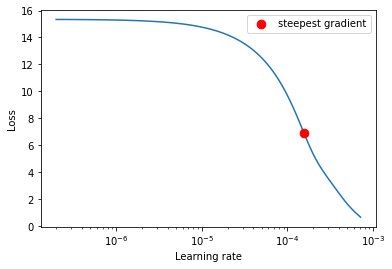

In [ ]:
dl = DataLoader(PoissonTorchTestDataset(plain_dataset=target_task), batch_size=1)

lr_finder = LRFinder(mtl_maml_solver, AdamGC(mtl_maml_solver.parameters(), lr=1e-7, use_gc=True, gc_conv_only=False, gc_loc=False), criterion=FakeLoss(), device="cuda")
lr_finder.range_test(dl, end_lr=100, num_iter=300)
_, suggested_lr = lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

### Fine-tuning pretrained meta-model

In [ ]:
lr_scale = 10 # smooth descending curve
mtl_mamal_solver_opt = AdamGC(mtl_maml_solver.parameters(), lr=lr_scale*suggested_lr, use_gc=True, gc_conv_only=False, gc_loc=False)

In [ ]:
# save the best chk and do MSE calculation to evaluate.
tuning_eps = 1000; best_loss = 1000
TMP_PATH = 'tmp.pth'
loss_tracks = []
all_loss_tracks = []

In [ ]:
for e in range(tuning_eps):
    mtl_mamal_solver_opt.zero_grad()
    loss, _ = mtl_maml_solver((F_data, B_data))
    loss.backward()
    mtl_mamal_solver_opt.step()

    if loss.item() < best_loss:
      best_loss = loss.item()
      torch.save(mtl_maml_solver.state_dict(), TMP_PATH)
      
    # tracking codes
    all_loss_tracks.append(loss.item())
    if (e+1)%10 == 0 or e==0:
        loss_tracks.append(loss.item())
        print(e+1, loss.item())

1 15.341192245483398
10 -1.5437464714050293
20 -2.942711353302002
30 -2.9429731369018555
40 -3.0802550315856934
50 -3.1368813514709473
60 -3.2204623222351074
70 -3.2601776123046875
80 -3.29028058052063
90 -3.3203396797180176
100 -3.354036808013916
110 -3.399216413497925
120 -3.468414783477783
130 -3.5317163467407227
140 -3.325523853302002
150 -3.5882139205932617
160 -3.6023950576782227
170 -3.654759407043457
180 -3.6853933334350586
190 -3.716686725616455
200 -3.7471742630004883
210 -3.7764034271240234
220 -3.7965598106384277
230 -3.8078489303588867
240 -3.8372602462768555
250 -3.8856425285339355
260 -3.9218993186950684
270 -3.9541168212890625
280 -3.985842227935791
290 -4.016458511352539
300 -3.553338050842285
310 -4.008100509643555
320 -4.064155578613281
330 -4.114880084991455
340 -4.158074855804443
350 -4.194862365722656
360 -4.227950096130371
370 -4.259309768676758
380 -4.207085609436035
390 -4.254693031311035
400 -4.326915264129639
410 -4.369609832763672
420 -4.407179832458496
430 

In [ ]:
mtl_maml_solver.load_state_dict(torch.load(TMP_PATH))

<All keys matched successfully>

### Ground-truth

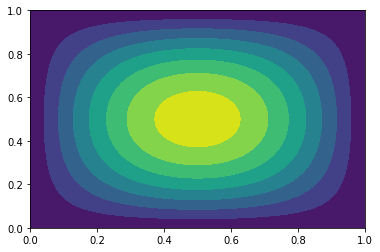

In [ ]:
def solution(x, y):
    return TEST_CONSTANT*(np.sin(np.pi*x)*np.sin(np.pi*y))/(2*np.pi**2)
solution = np.vectorize(solution)

delta = 0.005
x_test = np.arange(0, 1+delta, step=delta)
t_test = np.arange(0, 1+delta, step=delta)
xx, tt = np.meshgrid(x_test, t_test)
z = solution(xx, tt)

X_test = []
count = 0
for i in range(len(xx)):
    for j in range(len(tt)):
        X_test.append([xx[i][j], tt[i][j]])
X_test = np.array(X_test)
X_test = torch.tensor(X_test, requires_grad=False).float().cuda()

plt.contourf(x_test, t_test, z)
plt.show()

In [ ]:
actual_pde_solver_network = mtl_maml_solver.model.solver
actual_pde_solver_network.eval()
z_pred = actual_pde_solver_network(X_test)[0].reshape(len(xx), len(tt)).cpu().detach().numpy()

MAE: 0.005633920635921375
MSE: 6.291517850186218e-05
Relative l2-norm error: 0.08578036814649767


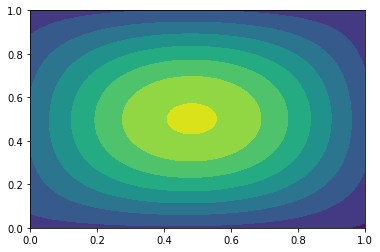

In [ ]:
plt.contourf(x_test, t_test, z_pred)

print('MAE:', mean_absolute_error(z_pred, z))
print('MSE:', mean_squared_error(z_pred, z))
print('Relative l2-norm error:', np.linalg.norm(z-z_pred,2)/np.linalg.norm(z,2))

In [ ]:
# History of constant = 3
# MAE: 0.006954800332785136
# MSE: 8.539573334244011e-05
# Relative l2-norm error: 0.11639637550340397

# Ranger 6e-3
# MAE: 0.009040752131407976
# MSE: 0.0001223033956755117
# Relative l2-norm error: 0.14228509133475856

# 10 * learning_rate_finder
# MAE: 0.005633920635921375
# MSE: 6.291517850186218e-05
# Relative l2-norm error: 0.08578036814649767

In [ ]:
torch.save(mtl_maml_solver.state_dict(), PATH+'best_finetuned_'+'mtl_sparse_metacurve_2048dims0.2sparse_poisson_gpu_36000tasks.pth')

### Comparing the models

In [ ]:
mtl_solver = MultiTaskLossWrapper(task_num=2, model=PhysicsInformedWrapper(solver=MLTSparseModel(INPUT_SIZE, SPARSE_HIDDEN_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).cuda())).cuda()
mtl_solver_opt = torch.optim.Adam(mtl_solver.parameters(), lr=6e-3)

In [ ]:
TMP2_PATH = 'tmp2.pth'
best_loss = 1000
loss_tracks2 = []
all_loss_tracks2 = []
for e in range(tuning_eps):
    mtl_solver_opt.zero_grad()
    loss, _ = mtl_solver((F_data, B_data))
    loss.backward()
    mtl_solver_opt.step()
    if loss.item() < best_loss:
      best_loss = loss.item()
      torch.save(mtl_solver.state_dict(), TMP2_PATH)
    all_loss_tracks2.append(loss.item())
    if (e+1)%100 == 0 or e==0:
        loss_tracks2.append(loss.item())

MAE: 0.00737215566709726
MSE: 7.409782905397705e-05
Relative l2-norm error: 0.08420689877688742


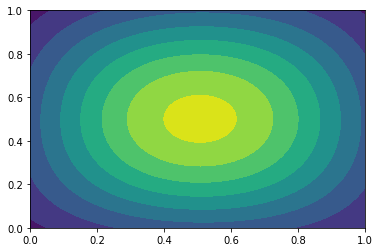

In [ ]:
mtl_solver.load_state_dict(torch.load('tmp2.pth'))
mtl_solver.eval()
z_pred = mtl_solver.model.solver(X_test)[0].reshape(len(xx), len(tt)).cpu().detach().numpy()

plt.contourf(x_test, t_test, z_pred)

print('MAE:', mean_absolute_error(z_pred, z))
print('MSE:', mean_squared_error(z_pred, z))
print('Relative l2-norm error:', np.linalg.norm(z-z_pred,2)/np.linalg.norm(z,2))

ValueError: ignored

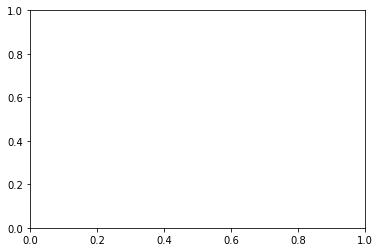

In [ ]:
plt.plot([i for i in range(0, 1001, 100)], loss_tracks, marker='v', label='Meta multi-task sparse solver')
plt.plot([i for i in range(0, 1001, 100)], loss_tracks2, marker='.', label='Multi-task sparse solver')
plt.xlabel('Epochs')
plt.ylabel('Fine-tuning loss')
plt.legend()
# plt.savefig(PATH+'meta_multi-task_sparse_network_solver4.png', dpi=300)
plt.show()
# With, MAML, the model converges "faster and smoothier"!.

In [ ]:
min(all_loss_tracks), min(all_loss_tracks2)

(-6.233449459075928, -7.950362682342529)

In [ ]:
loss_tracks, loss_tracks2

([15.341192245483398,
  -1.5437464714050293,
  -2.942711353302002,
  -2.9429731369018555,
  -3.0802550315856934,
  -3.1368813514709473,
  -3.2204623222351074,
  -3.2601776123046875,
  -3.29028058052063,
  -3.3203396797180176,
  -3.354036808013916,
  -3.399216413497925,
  -3.468414783477783,
  -3.5317163467407227,
  -3.325523853302002,
  -3.5882139205932617,
  -3.6023950576782227,
  -3.654759407043457,
  -3.6853933334350586,
  -3.716686725616455,
  -3.7471742630004883,
  -3.7764034271240234,
  -3.7965598106384277,
  -3.8078489303588867,
  -3.8372602462768555,
  -3.8856425285339355,
  -3.9218993186950684,
  -3.9541168212890625,
  -3.985842227935791,
  -4.016458511352539,
  -3.553338050842285,
  -4.008100509643555,
  -4.064155578613281,
  -4.114880084991455,
  -4.158074855804443,
  -4.194862365722656,
  -4.227950096130371,
  -4.259309768676758,
  -4.207085609436035,
  -4.254693031311035,
  -4.326915264129639,
  -4.369609832763672,
  -4.407179832458496,
  -4.440224647521973,
  -4.466280937